In [1]:
#import necessary modules
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch import optim as optim
from tqdm import tqdm
# for visualization
from matplotlib import pyplot as plt
import math
import numpy as np

# import from biotorch
from biotorch.layers import fa, usf, brsf, frsf

# tells PyTorch to use an NVIDIA GPU, if one is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# loading the dataset
training_parameters = {
    "img_size": 28,
    "n_epochs": 40, # 40 with brSF, 20 with bp
    "batch_size": 64,
    "learning_rate_generator": 0.0002, # 0.0002 with bp, 0.0002 with brsf
    "learning_rate_discriminator": 0.00004, # 0.0002 with bp, 0.00004 with brsf
    "training_model_generator": "brsf", # Specify one of "bp", "fa", "usf", "brsf", "frsf"
    "training_model_discriminator": "brsf", # Specify one of "bp", "fa", "usf", "brsf", "frsf"
}
# define a transform to 1) scale the images and 2) convert them into tensors
transform = transforms.Compose([
    transforms.Resize(training_parameters['img_size']), # scales the smaller edge of the image to have this size
    transforms.ToTensor(),
])

# load the dataset
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        './data', # specifies the directory to download the datafiles to, relative to the location of the notebook.
        train = True,
        download = True,
        transform = transform),
    batch_size = training_parameters["batch_size"],
    shuffle=True
    )

# Fashion MNIST has 10 classes, just like MNIST. Here's what they correspond to:
label_descriptions = {
      0: 'T-shirt/top',
      1	: 'Trouser',
      2	: 'Pullover',
      3	: 'Dress',
      4	: 'Coat',
      5	: 'Sandal',
      6	: 'Shirt',
      7	: 'Sneaker',
      8	: 'Bag',
      9	: 'Ankle boot'
}

In [3]:
# Create the Generator model class, which will be used to initialize the generator
class Generator(nn.Module):
  def __init__(self, input_dim, output_dim, num_labels=10, training_model = "bp"): # to initialize the model-wide parameters. When you run `generator = Generator(params)`, those "params" are passed to __init__.
    super(Generator,self).__init__() # initialize the parent class
    # TODO (5.4) Turn this Generator into a Conditional Generator by
    # 1. Adjusting the input dimension of the first hidden layer.
    # 2. Modifying the input to the first hidden layer in the forward class.
    # self.label_embedding = nn.Embedding(10, 10) # This function will be useful.
    if training_model == "bp":
        self.hidden_layer1 = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden_layer2 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden_layer3 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        self.hidden_layer4 = nn.Sequential(
            nn.Linear(1024, output_dim),
            nn.Tanh()
        )
    elif training_model == "fa":
        self.hidden_layer1 = nn.Sequential(
            fa.Linear(input_dim, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden_layer2 = nn.Sequential(
            fa.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden_layer3 = nn.Sequential(
            fa.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        self.hidden_layer4 = nn.Sequential(
            fa.Linear(1024, output_dim),
            nn.Tanh()
        )
    elif training_model == "usf":
        self.hidden_layer1 = nn.Sequential(
            usf.Linear(input_dim, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden_layer2 = nn.Sequential(
            usf.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden_layer3 = nn.Sequential(
            usf.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        self.hidden_layer4 = nn.Sequential(
            usf.Linear(1024, output_dim),
            nn.Tanh()
        )
    elif training_model == "brsf":
        self.hidden_layer1 = nn.Sequential(
            brsf.Linear(input_dim, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden_layer2 = nn.Sequential(
            brsf.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden_layer3 = nn.Sequential(
            brsf.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        self.hidden_layer4 = nn.Sequential(
            brsf.Linear(1024, output_dim),
            nn.Tanh()
        )
    elif training_model == "frsf":
        self.hidden_layer1 = nn.Sequential(
            frsf.Linear(input_dim, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden_layer2 = nn.Sequential(
            frsf.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden_layer3 = nn.Sequential(
            frsf.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        self.hidden_layer4 = nn.Sequential(
            frsf.Linear(1024, output_dim),
            nn.Tanh()
        )
  def forward(self, x, labels):
      output = self.hidden_layer1(x)
      output = self.hidden_layer2(output)
      output = self.hidden_layer3(output)
      output = self.hidden_layer4(output)
      return output.to(device)

class Discriminator(nn.Module):
    def __init__(self, input_dim, output_dim=1, num_labels=None, training_model = "bp"):
        super(Discriminator, self).__init__()
        if training_model == "bp":
            self.hidden_layer1 = nn.Sequential(
                nn.Linear(input_dim, 1024),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3)
            )

            self.hidden_layer2 = nn.Sequential(
                nn.Linear(1024, 512),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3)
            )

            self.hidden_layer3 = nn.Sequential(
                nn.Linear(512, 256),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3)
            )

            self.hidden_layer4 = nn.Sequential(
                nn.Linear(256, output_dim),
                nn.Sigmoid()
            )
        elif training_model == "fa":
            self.hidden_layer1 = nn.Sequential(
                fa.Linear(input_dim, 1024),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3)
            )

            self.hidden_layer2 = nn.Sequential(
                fa.Linear(1024, 512),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3)
            )

            self.hidden_layer3 = nn.Sequential(
                fa.Linear(512, 256),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3)
            )

            self.hidden_layer4 = nn.Sequential(
                fa.Linear(256, output_dim),
                nn.Sigmoid()
            )
        elif training_model == "usf":
            self.hidden_layer1 = nn.Sequential(
                usf.Linear(input_dim, 1024),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3)
            )

            self.hidden_layer2 = nn.Sequential(
                usf.Linear(1024, 512),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3)
            )

            self.hidden_layer3 = nn.Sequential(
                usf.Linear(512, 256),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3)
            )

            self.hidden_layer4 = nn.Sequential(
                usf.Linear(256, output_dim),
                nn.Sigmoid()
            )
        elif training_model == "brsf":
            self.hidden_layer1 = nn.Sequential(
                brsf.Linear(input_dim, 1024),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3)
            )

            self.hidden_layer2 = nn.Sequential(
                brsf.Linear(1024, 512),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3)
            )

            self.hidden_layer3 = nn.Sequential(
                brsf.Linear(512, 256),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3)
            )

            self.hidden_layer4 = nn.Sequential(
                nn.Linear(256, output_dim),
                nn.Sigmoid()
            )
        elif training_model == "frsf":
            self.hidden_layer1 = nn.Sequential(
                frsf.Linear(input_dim, 1024),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3)
            )

            self.hidden_layer2 = nn.Sequential(
                frsf.Linear(1024, 512),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3)
            )

            self.hidden_layer3 = nn.Sequential(
                frsf.Linear(512, 256),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3)
            )

            self.hidden_layer4 = nn.Sequential(
                frsf.Linear(256, output_dim),
                nn.Sigmoid()
            )

    def forward(self, x, labels=None): 
        output = self.hidden_layer1(x)
        output = self.hidden_layer2(output)
        output = self.hidden_layer3(output)
        output = self.hidden_layer4(output)
        return output.to(device)

In [4]:
discriminator = Discriminator(784,1, training_model = training_parameters["training_model_discriminator"]).to(device) # initialize both models, and load them to the GPU or CPU.
generator = Generator(100,784, training_model =training_parameters["training_model_generator"]).to(device)

discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=training_parameters['learning_rate_discriminator'])
generator_optimizer = optim.Adam(generator.parameters(), lr=training_parameters['learning_rate_generator'])

GANloss = torch.nn.BCELoss()

def train_generator(batch_size):
    generator_optimizer.zero_grad()
    
    noise = torch.randn(batch_size,100).to(device) 

    fake_labels_believed_true = torch.tensor([[1.0] for i in range(batch_size)]).to(device)

    fake_images = generator(noise, fake_labels_believed_true)

    fake_images_pred_labels = discriminator(fake_images)
    
    loss = GANloss(fake_images_pred_labels, fake_labels_believed_true)
    #loss = -torch.mean(fake_images_pred_labels) # Wasserstein GAN implementation
    loss.backward()
    generator_optimizer.step()
    loss = loss.to(torch.device("cpu"))
    return loss.detach()

def train_discriminator(batch_size, images, labels=None): # labels to be used in 5.4.
   
    discriminator_optimizer.zero_grad()

    noise = torch.randn(batch_size, 100).to(device)

    fake_labels = torch.tensor([[0.0] for i in range(batch_size)]).to(device)
    real_labels = torch.tensor([[1.0] for i in range(batch_size)]).to(device)

    fake_images = generator(noise, fake_labels)

    fake_images_pred_labels = discriminator(fake_images)

    fake_loss = GANloss(fake_images_pred_labels, fake_labels)
    #fake_loss = torch.mean(fake_images_pred_labels)  # wasserstein GAN implementation

    image_flatter = nn.Flatten()
    images = image_flatter(images.to(device))
    real_loss = GANloss(discriminator(images), real_labels)
    #real_loss = -torch.mean(discriminator(images))  # Wasserstein GAN implementation

    loss = fake_loss + real_loss
    loss.backward()
    discriminator_optimizer.step()
    loss = loss.to(torch.device("cpu"))
    return loss.detach()




 10%|████▍                                       | 4/40 [01:23<12:30, 20.86s/it]

Training Steps Completed:  499


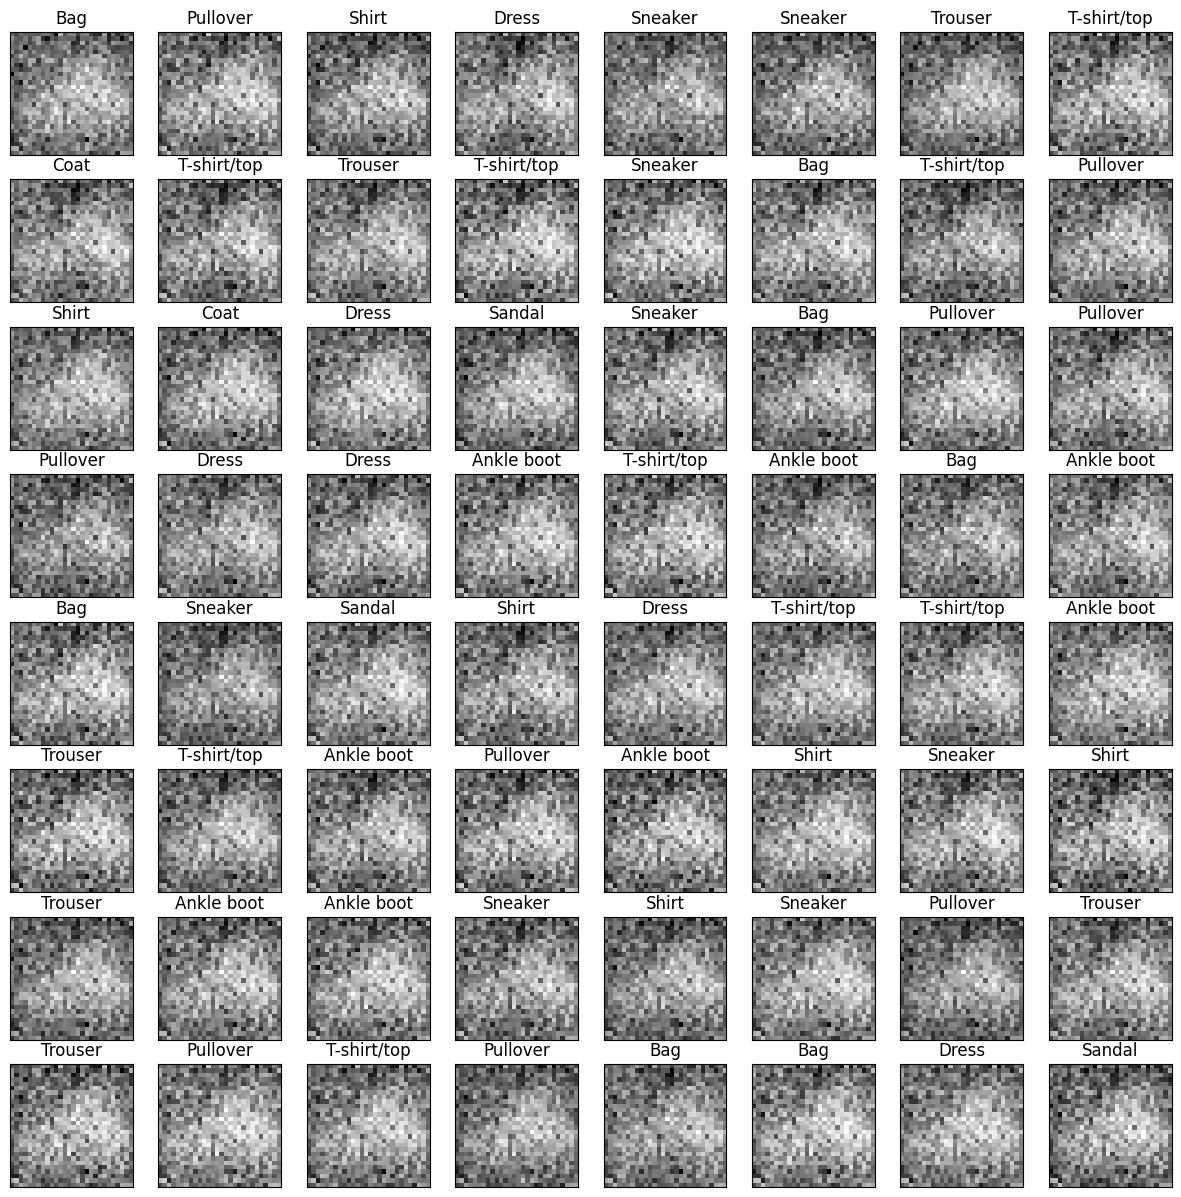

Epoch 4: loss_d: 1.0256706476211548, loss_g: 1.6995388269424438


 22%|█████████▉                                  | 9/40 [03:08<10:45, 20.84s/it]

Training Steps Completed:  499


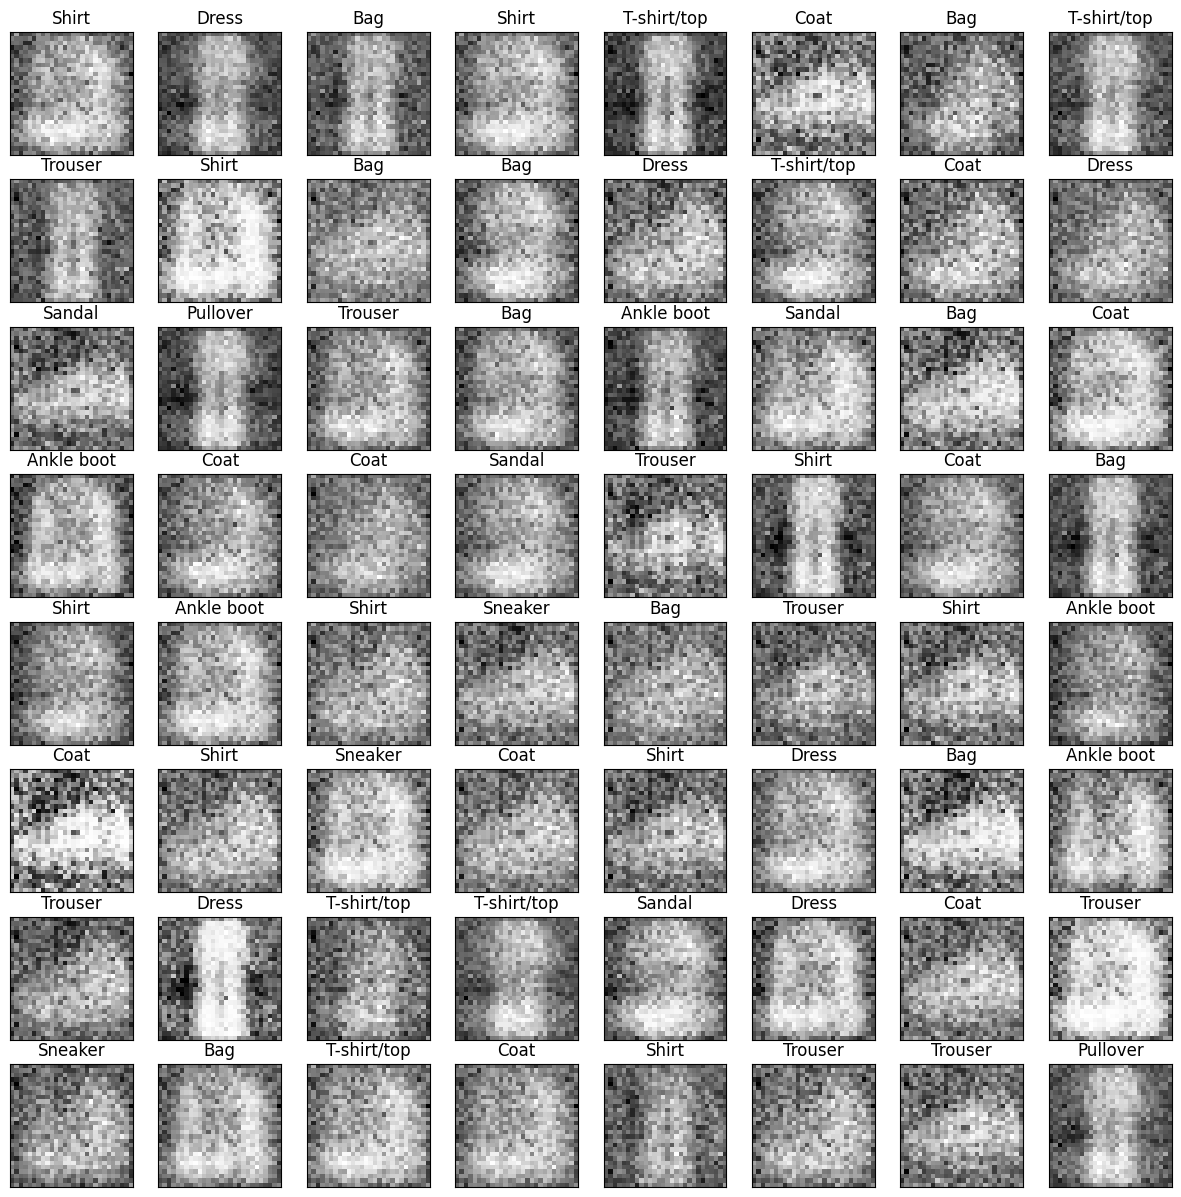

Epoch 9: loss_d: 1.083724021911621, loss_g: 1.3642288446426392


 35%|███████████████                            | 14/40 [04:52<08:59, 20.76s/it]

Training Steps Completed:  499


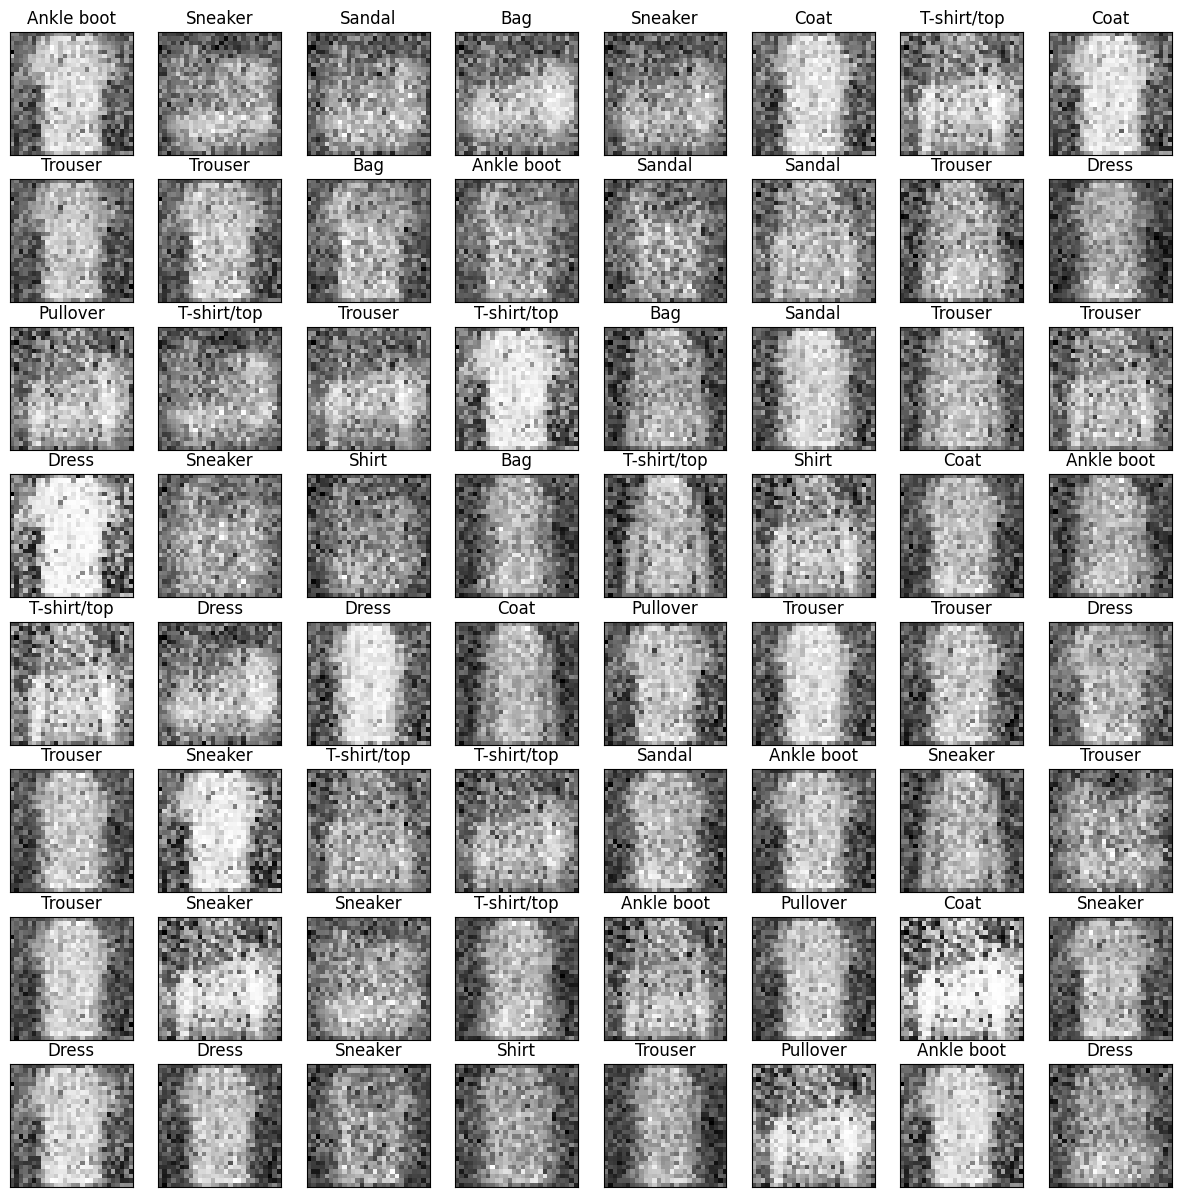

Epoch 14: loss_d: 1.0892254114151, loss_g: 1.2839982509613037


 48%|████████████████████▍                      | 19/40 [06:39<07:22, 21.05s/it]

Training Steps Completed:  499


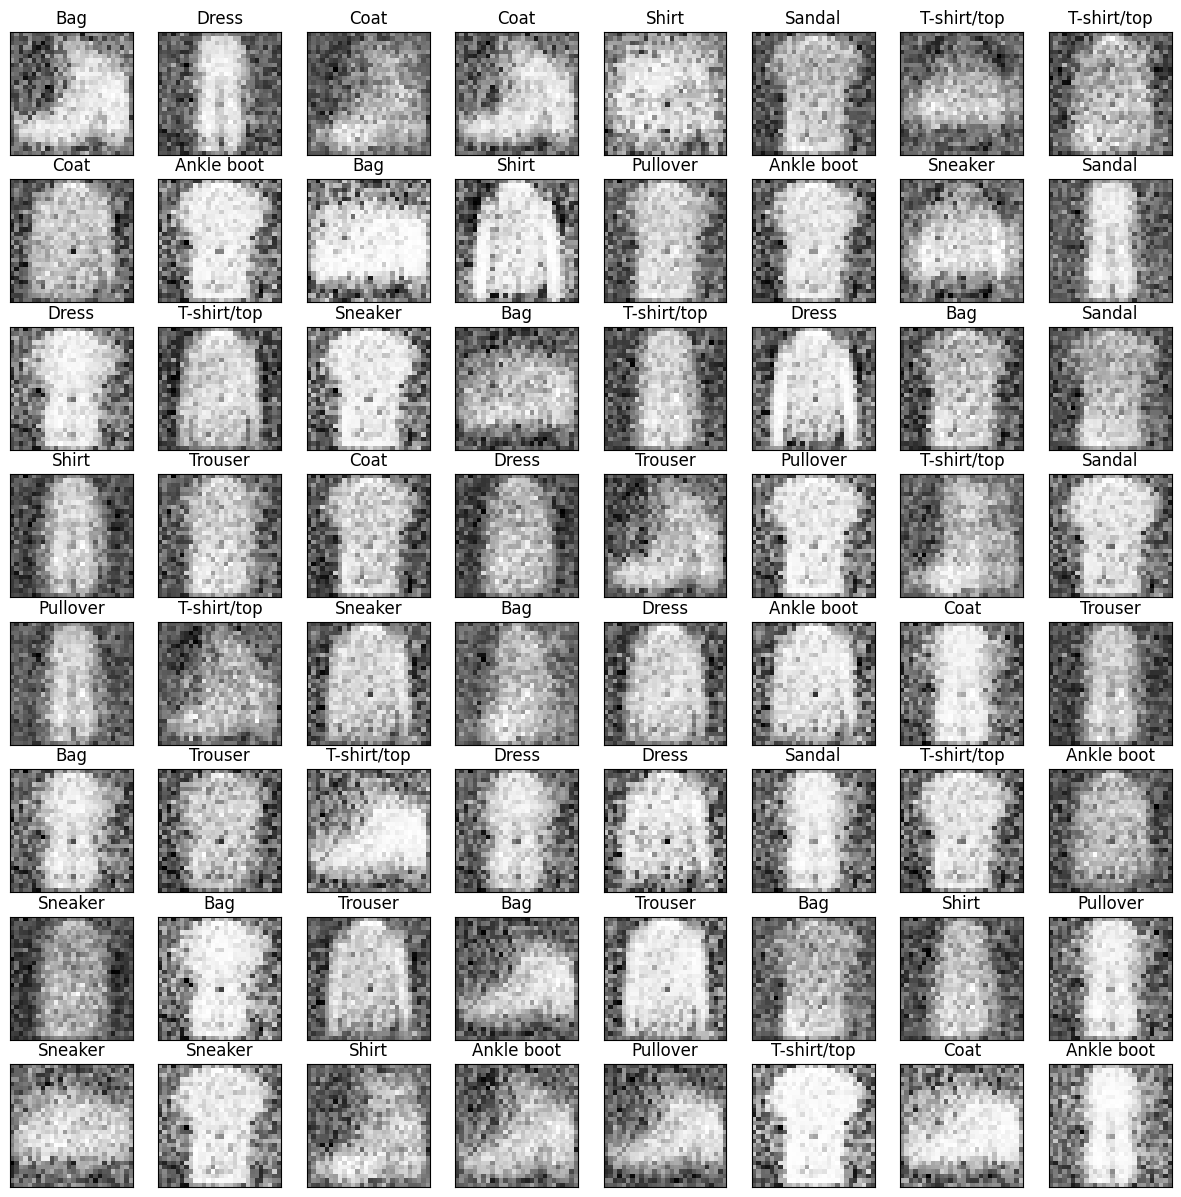

Epoch 19: loss_d: 1.0702340602874756, loss_g: 1.2700115442276


 60%|█████████████████████████▊                 | 24/40 [08:23<05:33, 20.82s/it]

Training Steps Completed:  499


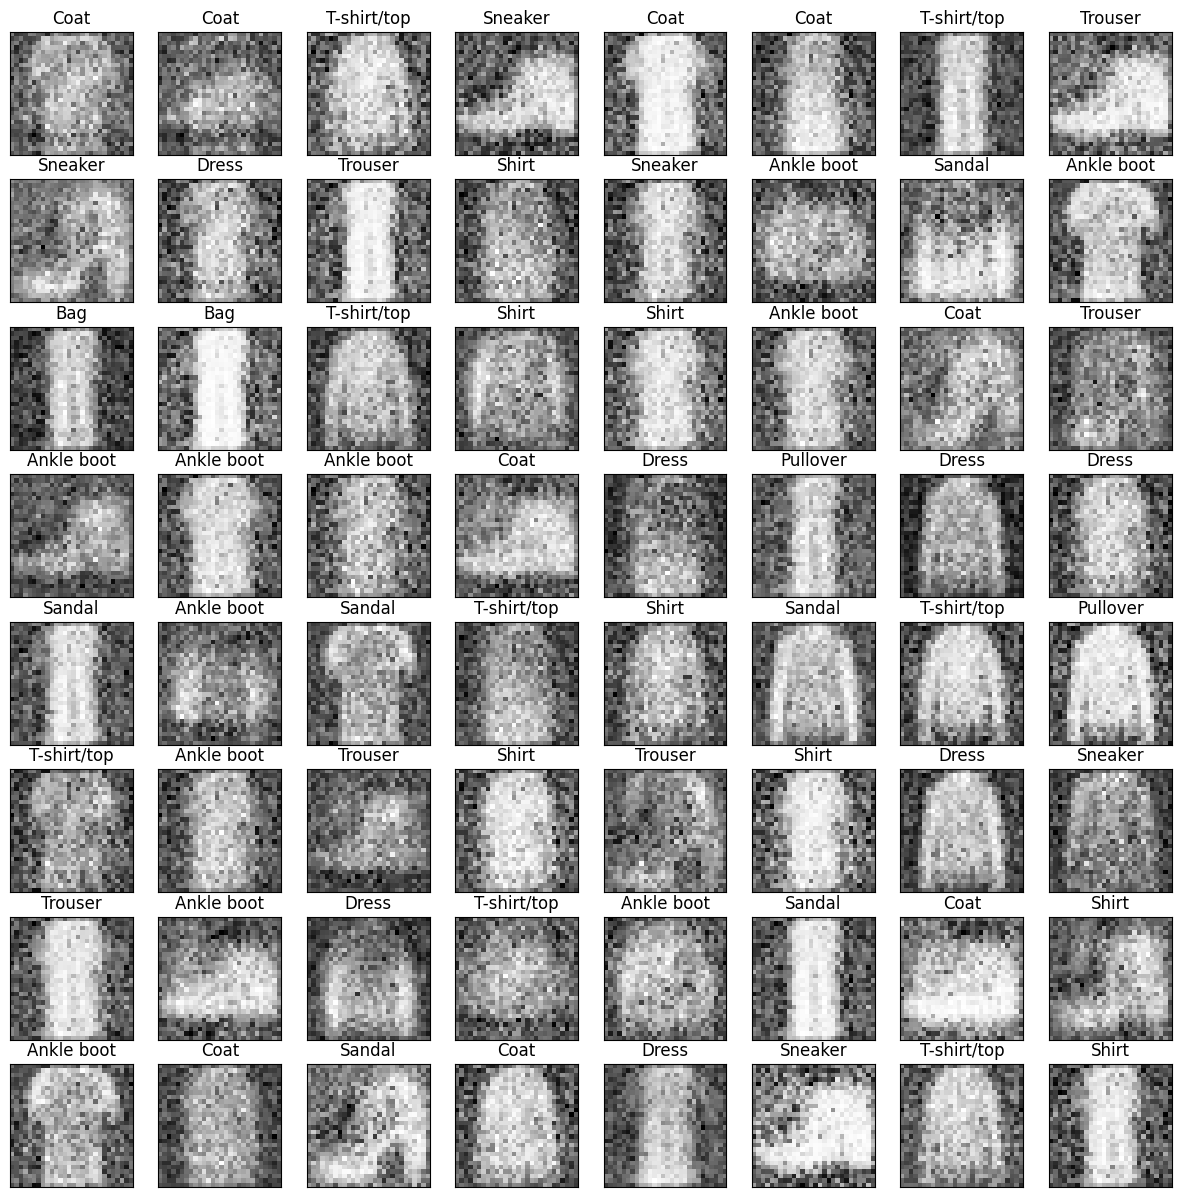

Epoch 24: loss_d: 1.0597748756408691, loss_g: 1.2594271898269653


 72%|███████████████████████████████▏           | 29/40 [10:08<03:48, 20.81s/it]

Training Steps Completed:  499


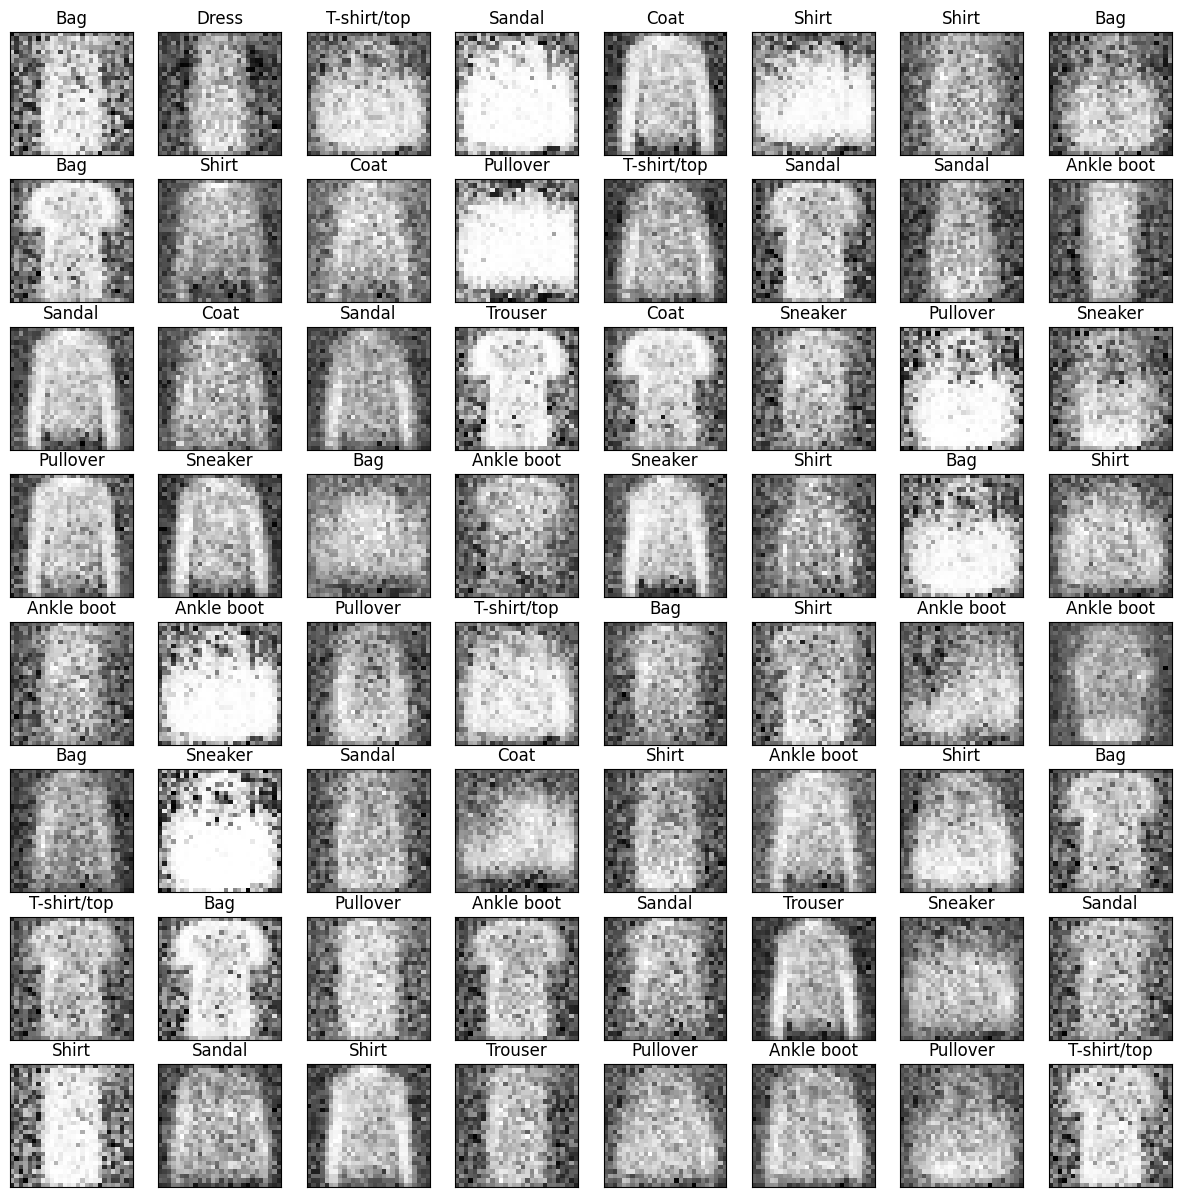

Epoch 29: loss_d: 1.0382254123687744, loss_g: 1.2775282859802246


 85%|████████████████████████████████████▌      | 34/40 [11:53<02:05, 20.99s/it]

Training Steps Completed:  499


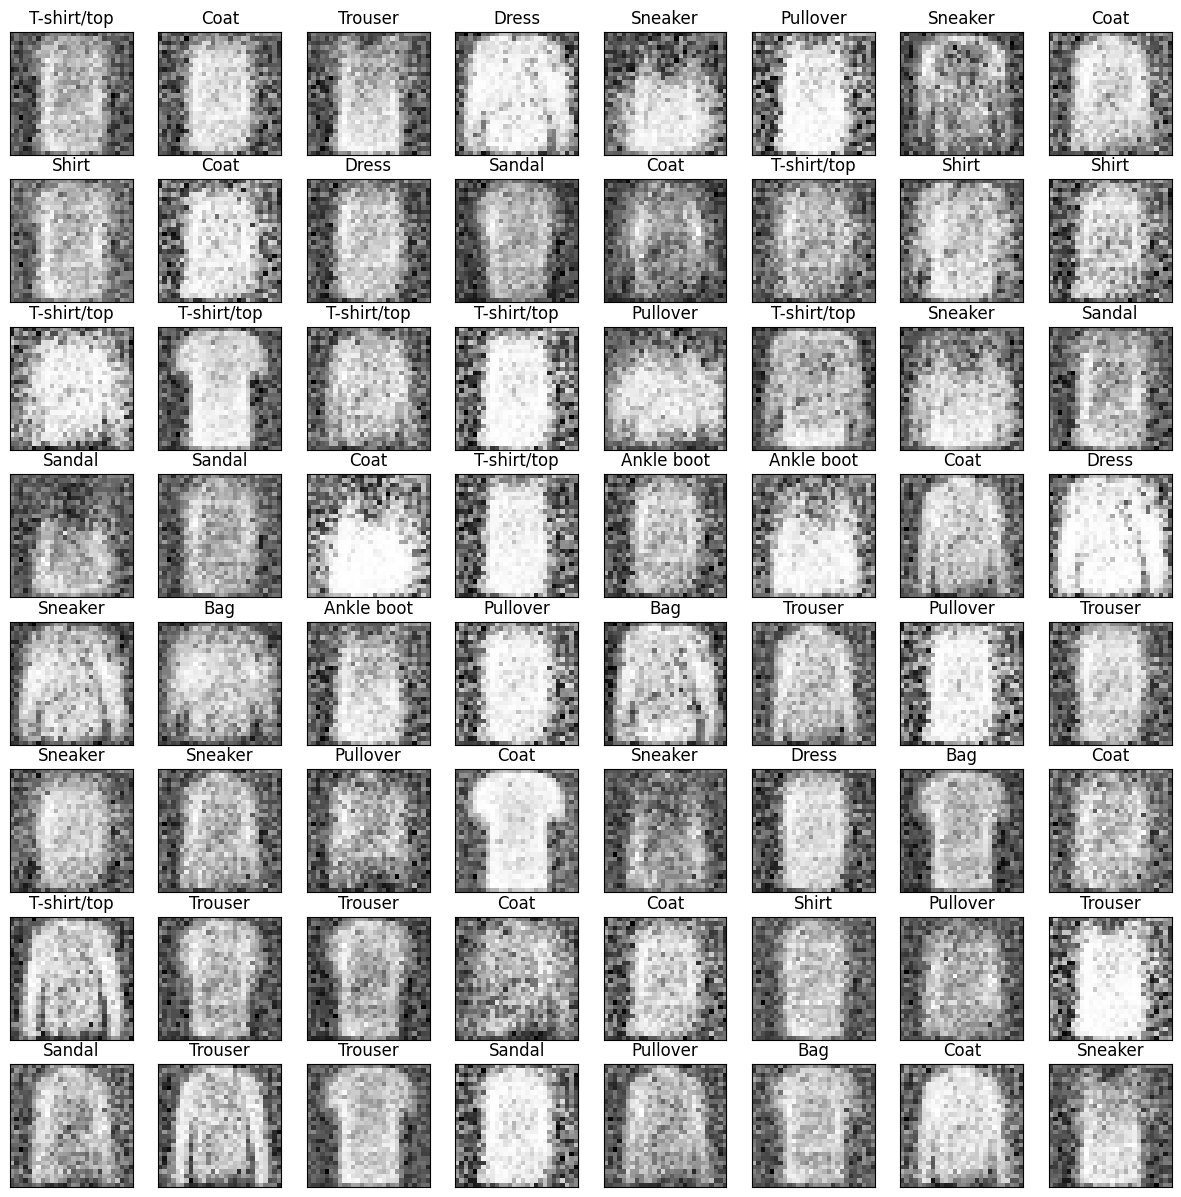

Epoch 34: loss_d: 1.0050841569900513, loss_g: 1.3265713453292847


 98%|█████████████████████████████████████████▉ | 39/40 [13:38<00:20, 20.92s/it]

Training Steps Completed:  499


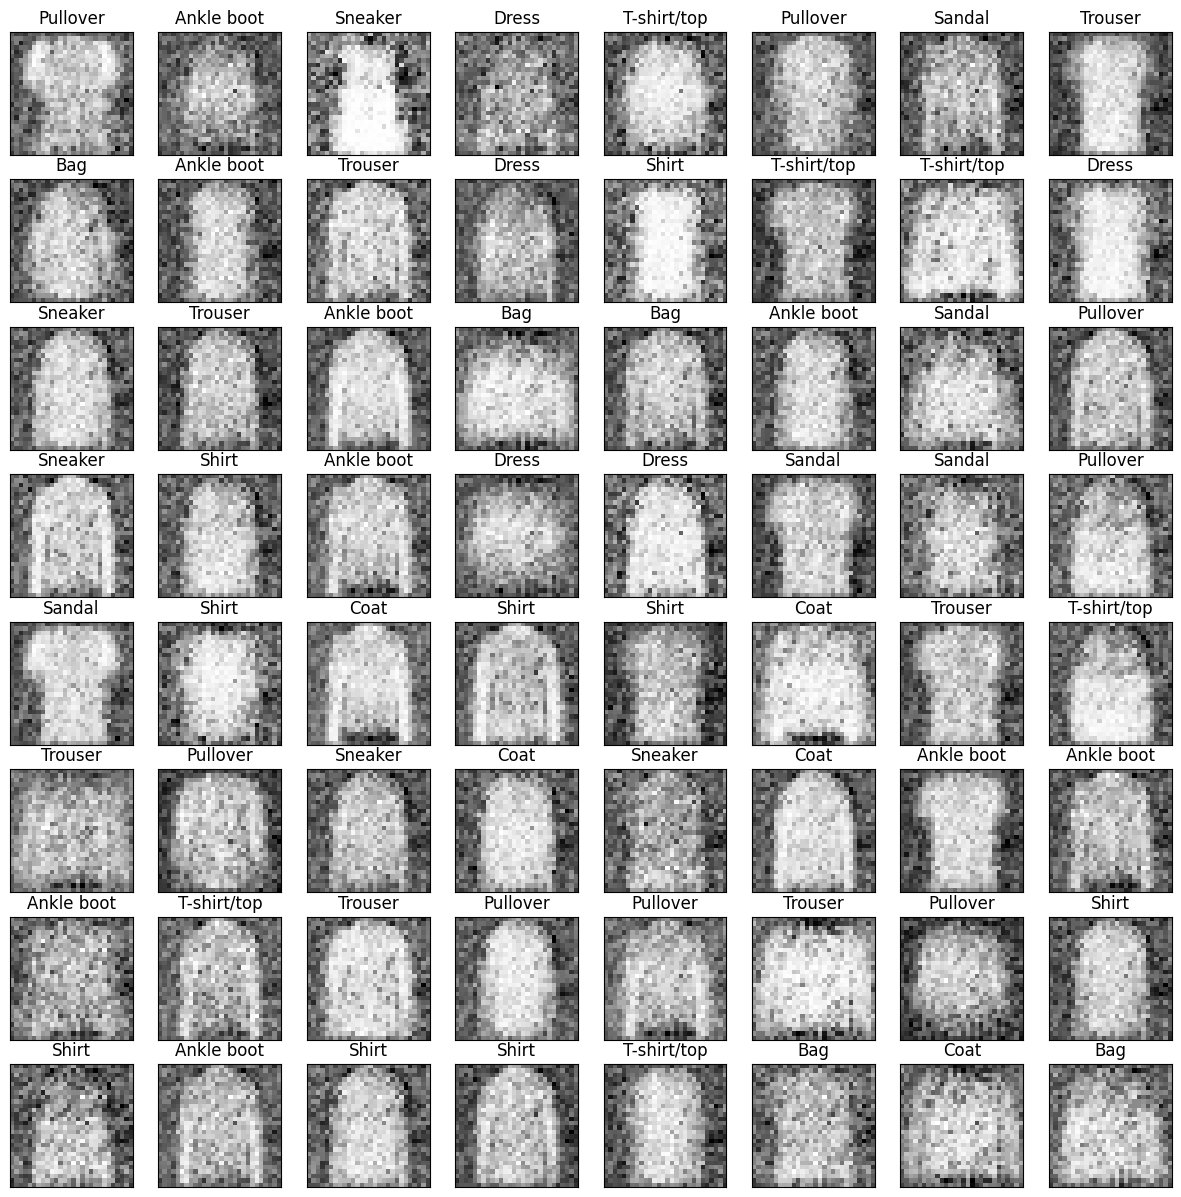

Epoch 39: loss_d: 0.9668803215026855, loss_g: 1.3968594074249268


100%|███████████████████████████████████████████| 40/40 [14:01<00:00, 21.03s/it]


In [5]:
G_loss = []  
D_loss = []
for epoch in tqdm(range(training_parameters['n_epochs'])):
    G_loss_per_epoch = []
    D_loss_per_epoch = []
    for batch, (imgs, labels) in enumerate(train_loader):
        batch_size = labels.shape[0]  # if the batch size doesn't evenly divide the dataset length, this may change on the last epoch.
        lossG = train_generator(batch_size)
        G_loss_per_epoch.append(lossG)
        lossD = train_discriminator(batch_size, imgs, labels)
        D_loss_per_epoch.append(lossD)

        if ((batch + 1) % 500 == 0 and (epoch + 1) % 5 == 0):
            # Display a batch of generated images and print the loss
            print("Training Steps Completed: ", batch)
            with torch.no_grad():  # disables gradient computation to speed things up
                noise = torch.randn(batch_size, 100).to(device)
                fake_labels = torch.randint(0, 10, (batch_size,)).to(device)
                generated_data = generator(noise, fake_labels).cpu().view(batch_size, 28, 28)

                # display generated images
                batch_sqrt = int(training_parameters['batch_size'] ** 0.5)
                fig, ax = plt.subplots(batch_sqrt, batch_sqrt, figsize=(15, 15))
                for i, x in enumerate(generated_data):
                    ax[math.floor(i / batch_sqrt)][i % batch_sqrt].set_title(
                        label_descriptions[int(fake_labels[i].item())] )
                    ax[math.floor(i / batch_sqrt)][i % batch_sqrt].imshow(x.detach().numpy(), interpolation='nearest', cmap='gray')
                    ax[math.floor(i / batch_sqrt)][i % batch_sqrt].get_xaxis().set_visible(False)
                    ax[math.floor(i / batch_sqrt)][i % batch_sqrt].get_yaxis().set_visible(False)
                plt.show()
                #fig.savefig(f"./results/CGAN_Generations_Epoch_{epoch}")
                print(
                    f"Epoch {epoch}: loss_d: {torch.mean(torch.FloatTensor(D_loss))}, loss_g: {torch.mean(torch.FloatTensor(G_loss))}")
    G_loss.append(np.mean(G_loss_per_epoch))
    D_loss.append(np.mean(D_loss_per_epoch))

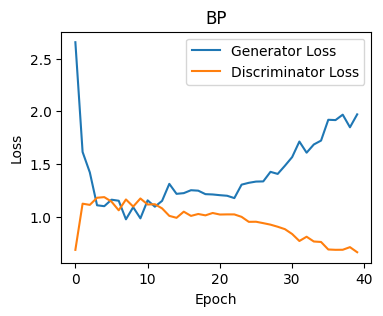

In [6]:
plt.figure(figsize = (4,3))
plt.plot(range(len(G_loss)), G_loss, label = "Generator Loss")
plt.plot(range(len(D_loss)), D_loss, label = "Discriminator Loss")
plt.xlabel("Epoch")
plt.title("brSF")
plt.ylabel("Loss")
plt.legend(loc = "best")
plt.show()